# Hidden markov models
We implement the small example found it the Wikipedia page dedicated to [hidden markov models](https://en.wikipedia.org/wiki/Hidden_Markov_model). We will use an implementation of the [Viterbi](https://jarrodkahn.com/posts/49/viterbi-algorithm) algorithm to find the most probable sequence of hidden states given the sequence of observations.

In [1]:
import numpy as np
import pandas as pd
import hmms
from numpy.linalg import eig
from matplotlib import pyplot as plt

## Wikipedia example

In [2]:
states = ('Rainy', 'Sunny')
 
observations = ('walk', 'shop', 'clean')
 
start_probability = {'Rainy': 0.6, 'Sunny': 0.4}
 
transition_probability = {
   'Rainy' : {'Rainy': 0.7, 'Sunny': 0.3},
   'Sunny' : {'Rainy': 0.4, 'Sunny': 0.6},
   }
 
emission_probability = {
   'Rainy' : {'walk': 0.1, 'shop': 0.4, 'clean': 0.5},
   'Sunny' : {'walk': 0.6, 'shop': 0.3, 'clean': 0.1},
   }

In [3]:
A = np.array([
    [0.7, 0.3],
    [0.4, 0.6]
])

B = np.array([
    [0.1, 0.4, 0.5],
    [0.6, 0.3, 0.1]
])

q_size = 2

q_init = 0

observed_variables = ['shop', 'walk', 'walk', 'shop', 'walk']
X = [observations.index(o) for o in observed_variables]

labels = [' Rainy', 'Sunny']

# Using the hmms library
Pi= np.array(list(start_probability.values()))
Pi = np.array([1,0])
dhmm = hmms.DtHMM(A,B,Pi)

# Using real sequence of observations
e_seq = np.array(X)
( log_prob, s_seq ) =  dhmm.viterbi( e_seq )
# Let's print the most likely state sequence, it can be same or differ from the sequence above.
hmms.plot_hmm( s_seq, e_seq )
print('Probability: ' + str(np.exp(log_prob)))

[' Rainy', ' Rainy', 'Sunny', 'Sunny', 'Sunny']

## Gene sequence example
This toy example is taken from this [paper](https://www.nature.com/articles/nbt1004-1315), where the sequence of observables is a nucleotide sequence, and the hidden states are the labels _exon_, _5'_ and _intron_.

![model](https://media.nature.com/lw926/nature-assets/nbt/journal/v22/n10/images/nbt1004-1315-F1.jpg)

Hence, we are predicting the most likely sequence of gene tags given the observed nucleotide sequence and the markov model provided in the paper. We are going to modify slighly the model presented in the paper. Specifically, we will no consider the begin and end states, since they do not have emission probabilities, consequently, the probability of transiting from intron to intron is changed to 1.

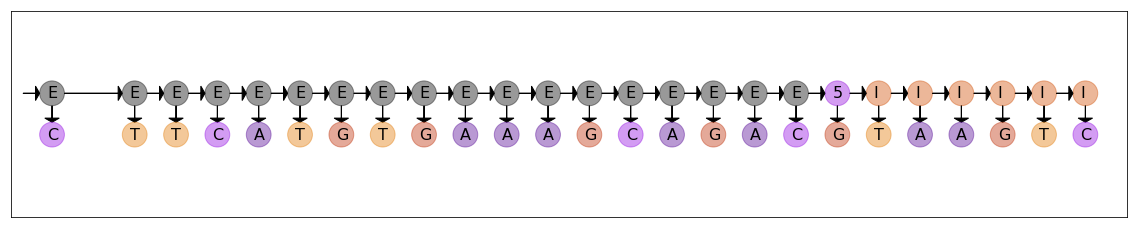

Probability: 2.360839041275283e-17


In [5]:
states = ('E', '5', 'I')
observations = ('A', 'C', 'G', 'T')

transition_probability = pd.DataFrame({
    'E' : {'E' : 0.9, '5' : 0.1, 'I' : 0},
    '5' : {'E' : 0, '5' : 0, 'I' : 1},
    'I' : {'E': 0, '5' : 0, 'I' : 1}
    }, index=['E','5','I']).transpose()


emission_probability = pd.DataFrame({
   'E' : {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T' : 0.25},
   '5' : {'A': 0.05, 'C': 0, 'G': 0.95, 'T' : 0},
   'I' : {'A': 0.4, 'C': 0.1, 'G': 0.1, 'T' : 0.4}
   }, index=['A','C','G','T']).transpose()


observed_variables = ['C','T','T','C','A','T','G','T','G','A','A','A','G',
                      'C','A','G','A','C','G','T','A','A','G','T','C','A']

X = [observations.index(o) for o in observed_variables]

# Using the hmms library
A = transition_probability.values
B = emission_probability.values
Pi = np.array([1,0,0])
dhmm = hmms.DtHMM(A,B,Pi)

# Using real sequence of observations
e_seq = np.array(X)
( log_prob, s_seq ) =  dhmm.viterbi( e_seq )
# Let's print the most likely state sequence, it can be same or differ from the sequence above.
plt.rcParams['figure.figsize'] = [20,20]
hmms.plot_hmm( s_seq, e_seq, state_labels=dict(zip(range(3),states)), 
              observation_labels=dict(zip(range(4),observations)), time=np.concatenate(([0], list(range(2, 26)))) )
print('Probability: ' + str(np.exp(log_prob)))

In [5]:
import inspect
inspect.getsourcefile(hmms)

'C:\\Users\\tinta\\Anaconda3\\lib\\site-packages\\hmms-0.1-py3.6-win-amd64.egg\\hmms\\__init__.py'

## On stationary distributions
An interesting property of a Markov model is the stationary distribution. This is a probability distribution of the states towards which the model tends to after a number of iterations. Note, however, that not all Markov model have a stationary distribution. The stationary distribution is a property of the transition matrix. In particular, given $A$, we have

$$x_{t+1} = x_t \mathrm{A}$$

which looks a lot like a right eigenvector with eigenvalue of 1, _i.e._

$$\mathrm{M}x = \lambda x \; \mathrm{with} \; \lambda=1$$

we only need to transpose the transition matrix, A:

$$x_{t+1}^T = (x_t \mathrm{A})^T = A^T x_t^T.$$

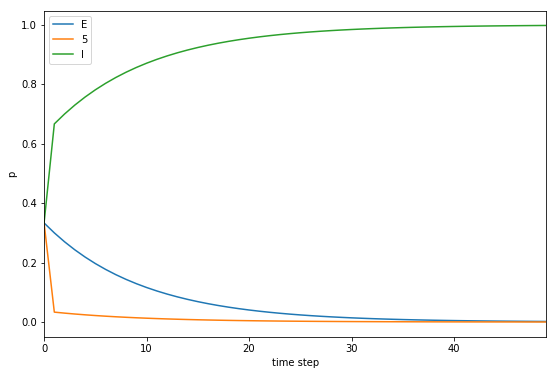

Stationary distribution:
{'E': 0.0019088056323407843, '5': 0.0002120895147045316, 'I': 0.9978791048529548}


In [13]:
# Let's continue with the transitio matrix of the previous example
P = transition_probability.values
n = P.shape[0]
x = np.array([1/n for _ in range(n)])

# First, let's iterate the Markov model to see if we find a stationary distribution
n_steps = 50
X = np.zeros((len(x), n_steps))
for n in range(n_steps):
    X[:, n] = x
    x = np.dot(x, P)
df = pd.DataFrame(data=X.transpose(), columns=transition_probability.columns)
df.plot(figsize=(9, 6))
plt.xlabel('time step')
plt.ylabel('p')
plt.legend()
plt.show()
print('Stationary distribution:')
print({s: X[i, n_steps - 1] for i, s in enumerate(states)})

We see that the iteration of our markov model suggest that the system evolves towards the intron state.

In [14]:
# Now let's find the stationary distribution by computing the eigenvectors and eigenvalues
w, v = eig(P.transpose())
lambda_1 = np.where(np.round(w, 6) == 1)[0]
v = np.array(v)
x = (v[:, lambda_1] / sum(v[:, lambda_1])).flatten().tolist()
print('Stationary distribution:')
print({s: x[i] for i, s in enumerate(states)})

Stationary distribution:
{'E': 0.0, '5': 0.0, 'I': 1.0}


The analysis of the left eigenvectors confirms that the stationary distribution consists of only introns, which is expectable since our markov model flows towards the intron state.

## Let's try a random stochastic matrix now

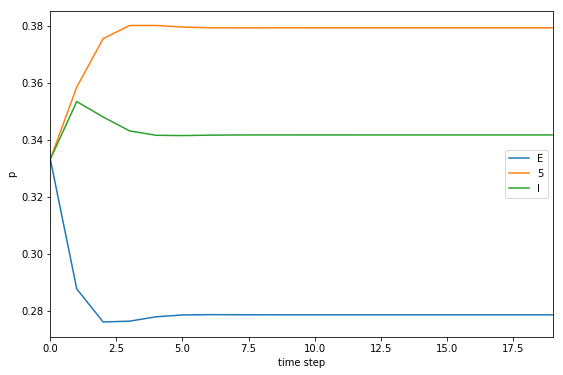

Stationary distribution:
{'E': 0.27876093873560837, '5': 0.37940108369457815, 'I': 0.34183797756981404}


In [19]:
P = np.random.rand(3, 3)
for c in range(P.shape[0]):
    P[c,:] = P[c,:] / sum(P[c,:])
n = P.shape[0]
x = np.array([1/n for _ in range(n)])

# First, let's iterate the Markov model to see if we find a stationary distribution
n_steps = 20
X = np.zeros((len(x), n_steps))
for n in range(n_steps):
    X[:, n] = x
    x = np.dot(x, P)
df = pd.DataFrame(data=X.transpose(), columns=transition_probability.columns)
df.plot(figsize=(9, 6))
plt.xlabel('time step')
plt.ylabel('p')
plt.legend()
plt.show()
print('Stationary distribution:')
print({s: X[i, n_steps - 1] for i, s in enumerate(states)})